# Jeopardy Topic Modelling
Goal: use unsupervised learning to analyze questions from the show

## Approach to Topic Modeling for this project:

For this project the approach taken for topic modelling was:

1. Partitioned the data into 90 parts using the Year and Question Type (Jeopardy!,Double Jeopardy!,Final Jeopardy!)
2. Applied 90 separate LDA models on each of these datasets to find the topic
3. Used **coherence score** to find the best k (number of topics) for LDA.
4. Using word_vectors similarity score, tried to find the similarity between different topics using the best topic which represented the document and the best words which represented the topic
5. Calculated the similarity trends across years, and noted the observations.

### Load packages and data

In [15]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

# import nltk
# nltk.download('stopwords')

In [42]:
df = pd.read_csv("JEOPARDY_CSV.csv")

In [43]:
df.head().T

,0,1,2,3,4
Show Number,4680,4680,4680,4680,4680
Air Date,2004-12-31,2004-12-31,2004-12-31,2004-12-31,2004-12-31
Round,Jeopardy!,Jeopardy!,Jeopardy!,Jeopardy!,Jeopardy!
Category,HISTORY,ESPN's TOP 10 ALL-TIME ATHLETES,EVERYBODY TALKS ABOUT IT...,THE COMPANY LINE,EPITAPHS & TRIBUTES
Value,$200,$200,$200,$200,$200
Question,"For the last 8 years of his life, Galileo was ...",No. 2: 1912 Olympian; football star at Carlisl...,The city of Yuma in this state has a record av...,"In 1963, live on ""The Art Linkletter Show"", th...","Signer of the Dec. of Indep., framer of the Co..."
Answer,Copernicus,Jim Thorpe,Arizona,McDonald's,John Adams


In [44]:
df.shape

(216930, 7)

In [45]:
df.columns

Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype='object')

### Question 1A
Investigate the topics of the show over time. 
<br>
Goal: we need to find topics for each year for each portion.

The first approach we try is CountVectorizer + LatentDirichletAllocation from sklearn.

In [46]:
df[' Air Date'] = df[' Air Date'].apply(pd.to_datetime)
df['Year'] = df[' Air Date'].apply(lambda x: x.year)

In [47]:
ques_lst = df.groupby(['Year', ' Round'])[' Question'].apply(list)
df1A = pd.DataFrame(ques_lst).reset_index()
df1A.head()

,Year,Round,Question
0,1984,Double Jeopardy!,[Some 40% of this country's land has been recl...
1,1984,Final Jeopardy!,[President elected to 2nd term with 523 electo...
2,1984,Jeopardy!,"[What the ""D.C."" stands for, Color of a lucky ..."
3,1985,Double Jeopardy!,"[“Hell no, we won't go” was a chant often hear..."
4,1985,Final Jeopardy!,"[Of the 4, blood group of the universal recipi..."


In [116]:
df1A[' Question'][0]

["Some 40% of this country's land has been reclaimed from the sea",
 'A wunnerful, wunnerful bandleader',
 'White supremacy group depicted as heroes in film classic "Birth of a Nation"',
 'This red bird is the state bird of 7 states',
 'Its name comes from the Middle English word "bumblen"',
 "Baby book author who ran for president in '68",
 "Both in size & population, it's largest Scandinavian country",
 'In 1937 he was "in the mood" to start a band',
 'Name of FBI "sting" operation that sent 4 former Congressmen to prison in \'83',
 'Depending on the species, a bird can have 940 to 25,000 of them',
 'Common name of an apiculturist',
 'Nickname of late Washington Senator Henry Jackson',
 '19th century Sardinia took the lead in unifying this country',
 'As famous for his marriages as his music; once wed Ava Gardner & Lana Turner',
 "32 inmates & 11 guards were killed in '71 uprising at this NY prison",
 'All 16 species of the Hawaiian honeycreeper are on this list',
 'A large crowd of 

In [132]:
vectorizer = CountVectorizer(stop_words=set(stopwords.words('english')))

n1A = len(df1A)

topic_collection = []

for i in range(n1A):
    X = vectorizer.fit_transform(df1A[' Question'][i])

    vocab = vectorizer.get_feature_names()

    k = 3

    model = LatentDirichletAllocation(n_components=k, random_state=100)
    id_topic = model.fit_transform(X)

    topic = []

    for comp in model.components_:    
        word_idx = np.argsort(comp)[-1]
        topic.append(vocab[word_idx])

    topic_collection.append(topic)

In [134]:
df1A['Topics'] = topic_collection
df1A.head()

,Year,Round,Question,Topics
0,1984,Double Jeopardy!,[Some 40% of this country's land has been recl...,"[first, name, famous]"
1,1984,Final Jeopardy!,[President elected to 2nd term with 523 electo...,"[rathbone, election, queen]"
2,1984,Jeopardy!,"[What the ""D.C."" stands for, Color of a lucky ...","[state, made, one]"
3,1985,Double Jeopardy!,"[“Hell no, we won't go” was a chant often hear...","[city, called, said]"
4,1985,Final Jeopardy!,"[Of the 4, blood group of the universal recipi...","[name, communist, year]"


Limitation: in the above case we choose topic=3, but we do not have scores for the evaluation.

### Calculate coherence values
After conducting some online research, we find there is a measure for topic clustering. 
<br>
reference: https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Load packages and help functions. Note: these functions are from the blog above. 

In [49]:
import spacy
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.corpora as corpora

In [145]:
stop_words = stopwords.words('english')
stop_words.extend(['href', 'http', 'html', 'wwwj', 'archivecom', 'www', 'br', 'jpg'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def compute_coherence_values(corpus, dictionary, k, data_lemmatized):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

For each row (represent a unique year and difficulty round) there are ten scores which are coherence values for the topic number K from 1 to 10. 

In [78]:
stop_words = stopwords.words('english')

cv_collection = []
n1A = len(df1A)

for i in range(n1A):
    data = df1A[' Question'][i]
    data_words = list(sent_to_words(data))
    
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['ADJ', 'NOUN']) #['NOUN', 'ADJ', 'VERB', 'ADV']
    id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
    cv = []
    for k in range(1, 11):
        cv.append(compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                                  k=k, data_lemmatized=data_lemmatized))
    print(f'{i}:{[round(x, 4) for x in cv]}')
    cv_collection.append(cv)

0:[0.7794, 0.7368, 0.7627, 0.7617, 0.751, 0.7608, 0.7509, 0.7461, 0.7217, 0.6993]
1:[0.7547, 0.554, 0.6276, 0.6628, 0.6754, 0.6854, 0.7213, 0.7257, 0.733, 0.7385]
2:[0.7774, 0.7652, 0.7643, 0.7605, 0.7647, 0.7642, 0.7556, 0.7687, 0.7481, 0.7124]
3:[0.7905, 0.7745, 0.7636, 0.7748, 0.7703, 0.7505, 0.7539, 0.7516, 0.7351, 0.6848]
4:[0.6295, 0.5787, 0.6384, 0.6616, 0.696, 0.6921, 0.7225, 0.7322, 0.7332, 0.7306]
5:[0.7896, 0.7689, 0.7766, 0.7587, 0.741, 0.7311, 0.7426, 0.7401, 0.7392, 0.6688]
6:[0.7303, 0.7249, 0.7036, 0.7079, 0.717, 0.7363, 0.712, 0.7165, 0.7133, 0.712]
7:[0.7653, 0.5261, 0.5497, 0.5823, 0.6085, 0.6138, 0.6445, 0.6683, 0.6803, 0.6938]
8:[0.7789, 0.7556, 0.7562, 0.7388, 0.7445, 0.7418, 0.758, 0.7338, 0.7549, 0.7181]
9:[0.7768, 0.7495, 0.7575, 0.7488, 0.7414, 0.7236, 0.7484, 0.7143, 0.7142, 0.7197]
10:[0.6143, 0.4252, 0.5409, 0.5407, 0.5815, 0.5675, 0.6586, 0.6789, 0.6932, 0.6974]
11:[0.7639, 0.7465, 0.7303, 0.7312, 0.7163, 0.7399, 0.7162, 0.7347, 0.736, 0.7195]
12:[0.7403, 

In [83]:
pd.DataFrame(cv_collection).to_csv("cv_collection.csv", index=False)

In [6]:
cv_collection = pd.read_csv("cv_collection.csv")
cv_collection

,0,1,2,3,4,5,6,7,8,9
0,0.779350,0.736799,0.762655,0.761730,0.750966,0.760823,0.750879,0.746117,0.721742,0.699327
1,0.754691,0.554038,0.627616,0.662778,0.675366,0.685448,0.721251,0.725657,0.732951,0.738489
2,0.777433,0.765183,0.764315,0.760494,0.764703,0.764186,0.755593,0.768660,0.748107,0.712400
3,0.790469,0.774549,0.763598,0.774786,0.770311,0.750454,0.753851,0.751561,0.735075,0.684846
4,0.629546,0.578680,0.638428,0.661619,0.696048,0.692128,0.722497,0.732170,0.733212,0.730556
...,...,...,...,...,...,...,...,...,...,...
85,0.706973,0.699598,0.689968,0.674656,0.674148,0.682982,0.678836,0.654269,0.662348,0.615611
86,0.549170,0.561426,0.560754,0.571988,0.589876,0.595774,0.603228,0.608374,0.621451,0.609287
87,0.732225,0.744609,0.738120,0.728922,0.716542,0.710484,0.716815,0.713895,0.713569,0.690699
88,0.585872,0.477443,0.516144,0.559166,0.566611,0.644369,0.651831,0.659106,0.672677,0.674550


We measure the result by the median metric, and take the second largest coherence value, since one topic is not interesting enough :)
<br>
Final choice: K = 6, and we choose N =3 such that each topic has 3 words. 

In [26]:
np.argsort(np.median(cv_collection.values, axis=0))[::-1] + 1

array([ 1,  6,  5,  7,  2,  8, 10,  9,  4,  3])

In [40]:
from pprint import pprint

In [146]:
n1A = len(df1A)

stop_words = stopwords.words('english')
stop_words.extend(['href', 'http', 'html', 'wwwj', 'archivecom', 'www', 'br', 'jpg'])

key_word = []

for i in range(n1A):
    data = df1A[' Question'][i]
    data_words = list(sent_to_words(data))
    
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['ADJ', 'NOUN']) #['NOUN', 'ADJ', 'VERB', 'ADV']
    id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=6, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10)
    w = np.array([x[1].split('"')[1:6:2] for x in lda_model.print_topics(num_words=3)]).flatten()
    print(f'{i}:{w}')
    key_word.append(w)

0:['state' 'long' 'planet' 'war' 'number' 'last' 'large' 'name' 'call'
 'team' 'world' 'word' 'country' 'large' 'day' 'people' 'film' 'body']
1:['lifespan' 'automobile' 'airplane' 'game' 'continent' 'city' 'country'
 'year' 'car' 'figure' 'greek' 'mythological' 'flag' 'steering' 'electric'
 'amendment' 'next' 'line']
2:['year' 'state' 'old' 'people' 'word' 'horse' 'race' 'number' 'horse'
 'name' 'word' 'friend' 'time' 'good' 'film' 'color' 'large' 'country']
3:['man' 'country' 'tooth' 'state' 'radio' 'high' 'name' 'year' 'century'
 'love' 'type' 'source' 'water' 'capital' 'title' 'death' 'german' 'state']
4:['state' 'color' 'different' 'actress' 'expense' 'year' 'justice' 'blood'
 'president' 'great' 'continent' 'country' 'name' 'word' 'full' 'blood'
 'justice' 'president']
5:['year' 'car' 'gum' 'man' 'way' 'number' 'film' 'movie' 'song' 'old'
 'charge' 'state' 'name' 'little' 'large' 'french' 'world' 'new']
6:['name' 'state' 'capital' 'country' 'last' 'record' 'war' 'title' 'book'
 'b

55:['large' 'man' 'french' 'famous' 'story' 'car' 'word' 'first' 'leader'
 'year' 'name' 'part' 'novel' 'country' 'number' 'medium' 'state' 'target']
56:['work' 'history' 'name' 'man' 'title' 'original' 'nation' 'country'
 'last' 'name' 'film' 'british' 'man' 'president' 'government' 'new'
 'woman' 'first']
57:['film' 'medium' 'target' 'people' 'company' 'food' 'medium' 'famous'
 'line' 'country' 'man' 'term' 'letter' 'day' 'eye' 'name' 'last' 'year']
58:['great' 'hogwart' 'wizard' 'many' 'alive' 'great' 'hogwart' 'many'
 'wizard' 'wizard' 'alive' 'great' 'wizard' 'alive' 'hogwart' 'hogwart'
 'wizard' 'great']
59:['medium' 'type' 'good' 'first' 'family' 'people' 'author' 'time' 'first'
 'country' 'name' 'company' 'man' 'film' 'part' 'year' 'state' 'famous']
60:['name' 'top' 'people' 'name' 'word' 'year' 'film' 'man' 'musical' 'day'
 'first' 'next' 'century' 'movie' 'woman' 'country' 'person' 'city']
61:['name' 'term' 'first' 'film' 'year' 'medium' 'state' 'novel' 'high'
 'country' 'ani

In [147]:
df1A['key_word'] = key_word

Save the result in a csv table
<br>
Attribute: 
<br>
year
<br>
round(difficulty level)
<br>
question list
<br>
key word list

In [148]:
df1A.to_csv('df1A.csv', index=False)

In [149]:
pd.read_csv('df1A.csv')

,Year,Round,Question,key_word
0,1984,Double Jeopardy!,"[""Some 40% of this country's land has been rec...",['state' 'long' 'planet' 'war' 'number' 'last'...
1,1984,Final Jeopardy!,['President elected to 2nd term with 523 elect...,['lifespan' 'automobile' 'airplane' 'game' 'co...
2,1984,Jeopardy!,"['What the ""D.C."" stands for', 'Color of a luc...",['year' 'state' 'old' 'people' 'word' 'horse' ...
3,1985,Double Jeopardy!,"[""“Hell no, we won't go” was a chant often hea...",['man' 'country' 'tooth' 'state' 'radio' 'high...
4,1985,Final Jeopardy!,"['Of the 4, blood group of the universal recip...",['state' 'color' 'different' 'actress' 'expens...
...,...,...,...,...
85,2011,Final Jeopardy!,"['At the University of Bonn in 1836, he was wo...",['word' 'year' 'time' 'country' 'name' 'charac...
86,2011,Jeopardy!,['The prospect of an endless lawsuit winding t...,['name' 'word' 'good' 'medium' 'target' 'great...
87,2012,Double Jeopardy!,['In December 1974 this former New York govern...,['large' 'term' 'first' 'man' 'year' 'title' '...
88,2012,Final Jeopardy!,"['When asked for a home address in ""The Blues ...",['record' 'film' 'picture' 'huge' 'cash' 'crop...


### Question 1B
<br>
Use word2vec to calculate similarity
<br>
Download the built-in word vectors

In [34]:
import gensim.downloader
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
print(list(gensim.downloader.info()['models'].keys()))
# word_vectors = gensim.downloader.load('word2vec-google-news-300')
# word_vectors.save('vectors.kv')
word_vectors = KeyedVectors.load('vectors.kv')

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


The bigger values are, it means the relationship between the two is close!

In [33]:
word_vectors.most_similar('earth')

[('Earth', 0.7105128169059753),
 ('planet', 0.6802847981452942),
 ('meek_inheriting', 0.5625147223472595),
 ('earths', 0.531245768070221),
 ('cosmos', 0.5272278785705566),
 ('mankind', 0.5163297653198242),
 ('mega_vertebrate', 0.5102849006652832),
 ('shepherded_Tolkien_Middle', 0.5001775026321411),
 ('ERDAS_creates', 0.4907360374927521),
 ('Martian_surface', 0.480654239654541)]

check some similarity values

In [104]:
print(word_vectors.similarity('large', 'small'))
print(word_vectors.similarity('white', 'black'))
print(word_vectors.similarity('large', 'black'))

0.733115
0.80922145
0.2655745


### Exaple: 
18 words (6 topic * 3 word) 
<br>
<br>
w1  - 1984 & double Jeopardy
<br>
w2 - 1984 & final Jeopardy

In [139]:
w1 = df1A['key_word'][0]
w2 = df1A['key_word'][1]
print(w1)
print(w2)

['body' 'earth' 'name' 'state' 'word' 'land' 'long' 'world' 'year' 'war'
 'last' 'first' 'country' 'good' 'large' 'name' 'people' 'famous']
['lifespan' 'automobile' 'airplane' 'game' 'continent' 'city' 'country'
 'year' 'car' 'figure' 'greek' 'mythological' 'flag' 'steering' 'electric'
 'amendment' 'next' 'line']


We have a score for each two word from the lists.

In [140]:
pd.DataFrame([[word_vectors.similarity(x1, x2) for x1 in w1] for x2 in w2]).shape

(18, 18)

And we focus what is the closest relationship between one word from w1 to another in w2, so apply the np.max function.

In [141]:
[np.max([word_vectors.similarity(x1, x2) for x1 in w1]) for x2 in w2]

[0.22673893,
 0.19111785,
 0.21439527,
 0.22676174,
 0.6130886,
 0.4119057,
 1.0,
 1.0,
 0.25992066,
 0.25107676,
 0.2369679,
 0.31309533,
 0.20709771,
 0.100657694,
 0.1000152,
 0.19764882,
 0.5478113,
 0.15716021]

There are 18 values then, and we can see they are two 1.0 it means two topic words are exactly the same.
<br>
We take the mean to calculate the overall similarity performance between the two lists. 

In [142]:
np.mean([np.max([word_vectors.similarity(x1, x2) for x1 in w1]) for x2 in w2])

0.34752554

we then calculate the score for the whole dataframe.

In [163]:
def similarity_score(w1, w2):
    w1 = [x1 for x1 in w1 if x1 in word_vectors.index_to_key]
    w2 = [x2 for x2 in w2 if x2 in word_vectors.index_to_key]
    return np.mean([np.max([word_vectors.similarity(x1, x2) for x1 in w1]) for x2 in w2])

In [169]:
score_collection = []
for i in df1A.key_word:
    score_collection.append([similarity_score(i, j) for j in df1A.key_word])

In [172]:
pd.DataFrame(score_collection).to_csv("score_collection.csv", index=False)

In [173]:
score_collection = pd.read_csv("score_collection.csv")
score_collection

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
0,1.000000,0.333549,0.649278,0.424108,0.446531,0.552421,0.663169,0.479635,0.644858,0.618406,...,0.544360,0.495118,0.563549,0.640807,0.624051,0.580631,0.519680,0.513185,0.399036,0.445093
1,0.359790,1.000000,0.348137,0.336522,0.335278,0.357908,0.394675,0.391184,0.492753,0.395539,...,0.354844,0.326277,0.428190,0.458403,0.375843,0.458257,0.306976,0.383970,0.308225,0.395520
2,0.670046,0.345083,1.000000,0.463883,0.531302,0.613481,0.601823,0.496681,0.680811,0.580397,...,0.550955,0.479893,0.564588,0.608772,0.705211,0.666999,0.606563,0.506517,0.440436,0.509979
3,0.432128,0.339909,0.466720,1.000000,0.453477,0.464529,0.548684,0.478489,0.581742,0.555930,...,0.616409,0.488613,0.562480,0.543295,0.442844,0.636497,0.445572,0.542488,0.418896,0.497736
4,0.482891,0.339854,0.582000,0.459786,1.000000,0.426837,0.501136,0.441533,0.590381,0.480160,...,0.485398,0.434206,0.557041,0.528755,0.513533,0.632986,0.521248,0.426119,0.400721,0.499409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.491903,0.378116,0.584276,0.500846,0.543446,0.515002,0.508851,0.440680,0.670113,0.575813,...,0.549500,0.574145,0.698145,0.658485,0.566027,1.000000,0.506125,0.558566,0.408581,0.561730
86,0.509144,0.296428,0.591799,0.471085,0.431849,0.414459,0.511036,0.362203,0.571692,0.508607,...,0.677620,0.611693,0.481546,0.618920,0.629617,0.570139,1.000000,0.616757,0.351652,0.784126
87,0.542824,0.341736,0.502126,0.510415,0.422408,0.436224,0.593669,0.466908,0.546770,0.645170,...,0.658045,0.531854,0.562520,0.672426,0.668847,0.666253,0.657149,1.000000,0.373345,0.727224
88,0.460993,0.322118,0.469531,0.421809,0.417672,0.469854,0.526216,0.365858,0.489268,0.454520,...,0.437589,0.378128,0.411918,0.431918,0.437741,0.549733,0.387679,0.394002,1.000000,0.406746


Below we check the orders of df1A

In [190]:
df1A.loc[df1A[' Round']=='Double Jeopardy!'].index

Int64Index([ 0,  3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 43, 46, 49,
            52, 55, 59, 62, 65, 68, 71, 75, 78, 81, 84, 87],
           dtype='int64')

In [192]:
df1A.loc[df1A[' Round']=='Final Jeopardy!'].index

Int64Index([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 44, 47, 50,
            53, 56, 60, 63, 66, 69, 72, 76, 79, 82, 85, 88],
           dtype='int64')

In [191]:
df1A.loc[df1A[' Round']=='Jeopardy!'].index

Int64Index([ 2,  5,  8, 11, 14, 17, 20, 23, 26, 29, 32, 35, 38, 41, 45, 48, 51,
            54, 57, 61, 64, 67, 70, 73, 77, 80, 83, 86, 89],
           dtype='int64')

In [197]:
df1A['Year']

0     1984
1     1984
2     1984
3     1985
4     1985
      ... 
85    2011
86    2011
87    2012
88    2012
89    2012
Name: Year, Length: 90, dtype: int64

In [205]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Plot that compares each year's question similarity to the first year's round (1984)

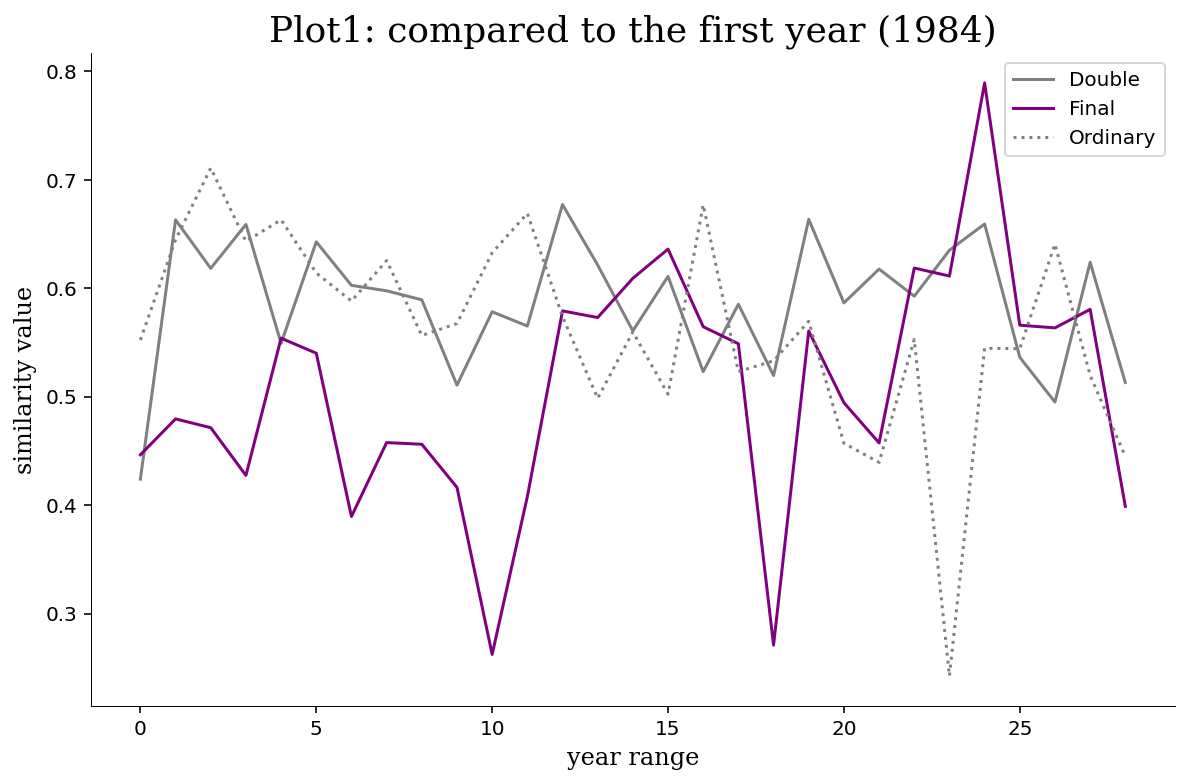

In [284]:
fig, ax = plt.subplots(figsize=(6*1.618, 6))     
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

labels = ['Double', 'Final', 'Ordinary']
colors = ['grey', 'purple', 'grey']
markers = ['-', '-', ':']

for i in range(3):
    # we get rid of the first record since it don't need to compare with itself, thus only 29 records left for each round
    ax.plot(np.arange(29), 
            score_collection.iloc[0][3+i::3], 
            markers[i],
            lw=1.5, 
            label=labels[i],
            markersize=8,
            color=colors[i])
    
ax.set_ylabel("similarity value",          fontsize=12, fontname='Serif')
ax.set_xlabel("year range",                fontsize=12, fontname='Serif')
ax.set_title("Plot1: compared to the first year (1984)", fontsize=18, fontname='Serif')
    
plt.legend()
plt.show()

Statistic Table 1

In [250]:
pd.DataFrame([score_collection.iloc[0][3+0::3].values,
              score_collection.iloc[0][3+1::3].values,
              score_collection.iloc[0][3+2::3].values]).T \
.rename(columns={0: "Double", 1: "Final", 2: "Ordinary"}).describe()

,Double,Final,Ordinary
count,29.000000,29.000000,29.000000
mean,0.587030,0.508052,0.561847
std,0.060124,0.110467,0.093293
min,0.424108,0.262482,0.242624
25%,0.549361,0.446531,0.523220
50%,0.592744,0.540179,0.559812
75%,0.624051,0.573072,0.632752
max,0.677287,0.789389,0.710910


Generate plot that compared to the previous year's round

In [234]:
score_list = []
for i in range(87):
    score_list.append(score_collection.iloc[i, i+3])

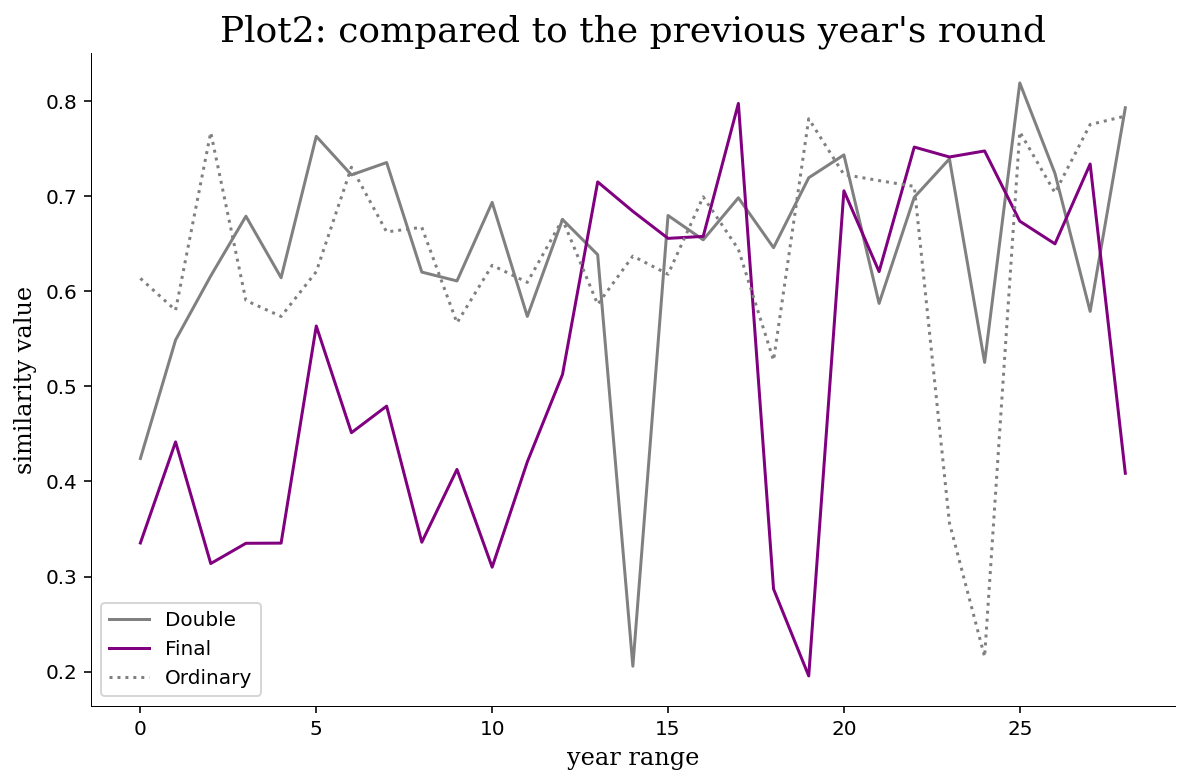

In [283]:
fig, ax = plt.subplots(figsize=(6*1.618, 6))     
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

labels = ['Double', 'Final', 'Ordinary']
colors = ['grey', 'purple', 'grey']
markers = ['-', '-', ':']

for i in range(3):
    # we get rid of the first record since it don't need to compare with itself, thus only 29 records left for each round
    ax.plot(np.arange(29), 
            score_list[i::3], 
            markers[i],
            lw=1.5, 
            label=labels[i],
            markersize=8,
            color=colors[i])
    
    
ax.set_ylabel("similarity value",          fontsize=12, fontname='Serif')
ax.set_xlabel("year range",                fontsize=12, fontname='Serif')
ax.set_title("Plot2: compared to the previous year's round", fontsize=18, fontname='Serif')
    

plt.legend()
plt.show()

Statistic Table 2

In [251]:
pd.DataFrame([score_list[0::3],
              score_list[1::3],
              score_list[2::3]]).T \
.rename(columns={0: "Double", 1: "Final", 2: "Ordinary"}).describe()

,Double,Final,Ordinary
count,29.000000,29.000000,29.000000
mean,0.645677,0.526552,0.638889
std,0.120078,0.178691,0.122754
min,0.205710,0.195455,0.215628
25%,0.610796,0.336081,0.590257
50%,0.675404,0.512451,0.644049
75%,0.722287,0.683989,0.716309
max,0.818997,0.797466,0.784126


Compare the similarity score between double-ordinary, double-final, ordinary-final in the same year

In [270]:
double_final = []
double_ordinary = []
final_ordinary = []
for i in range(90)[0:90:3]:
    double_final.append(score_collection.iloc[i, i+1])
    double_ordinary.append(score_collection.iloc[i, i+2])
    final_ordinary.append(score_collection.iloc[i+1, i+2])

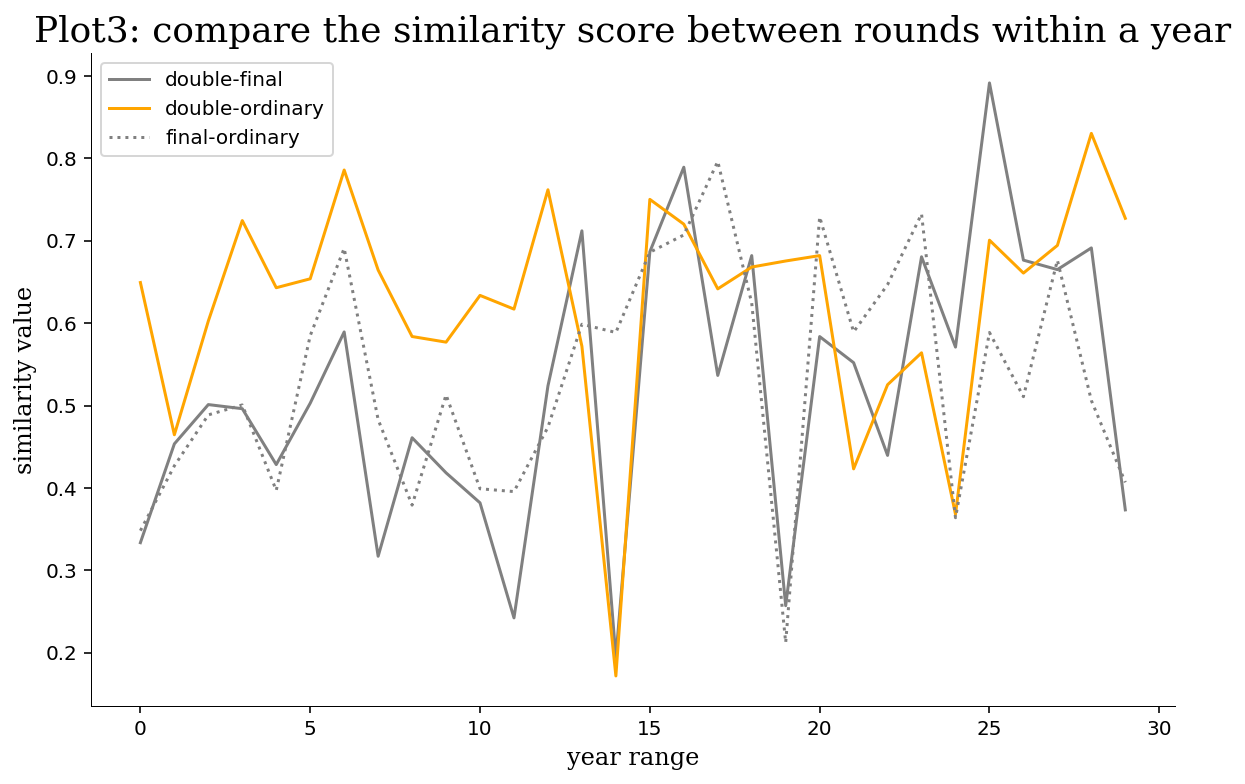

In [286]:
fig, ax = plt.subplots(figsize=(6*1.618, 6))     
ax.spines['top'].set_visible(False)  
ax.spines['right'].set_visible(False)
ax.spinehttp://localhost:8948/notebooks/Desktop/LDA%20Project/Case_Studies_Project.ipynb#s['left'].set_linewidth(.5)
ax.spines['bottom'].set_linewidth(.5)

values = [double_final, double_ordinary, final_ordinary]
labels = ['double-final', 'double-ordinary', 'final-ordinary']
colors = ['grey', 'orange', 'grey']
markers = ['-', '-', ':']


for i in range(3):
    # we get rid of the first record since it don't need to compare with itself, thus only 29 records left for each round
    ax.plot(np.arange(30), 
            values[i], 
            markers[i],
            lw=1.5, 
            label=labels[i],
            markersize=8,
            color=colors[i])
    
    
ax.set_ylabel("similarity value",          fontsize=12, fontname='Serif')
ax.set_xlabel("year range",                fontsize=12, fontname='Serif')
ax.set_title("Plot3: compare the similarity score between rounds within a year", fontsize=18, fontname='Serif')
    

plt.legend()
plt.show()

In [641]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                   id2word=id2word,
                                   num_topics=6, 
                                   random_state=100,
                                   chunksize=100,
                                   passes=10,
                                   decay=0.8,
                                      workers=6,
                                      offset=10,
                                    per_word_topics=True,
                                       minimum_phi_value=0.01
                                      )

    
#     doc_lda = lda_model[corpus]

In [655]:
lda_output=lda_model.print_topics(num_words=20)

In [656]:
topics_found=np.array([x[1].split('"')[1:len(x[1].split('"')):2] for x in lda_output])

In [657]:
topics_found

array([['author', 'song', 'story', 'city', 'house', 'time', 'title',
        'death', 'book', 'life', 'people', 'report', 'street',
        'clue_crew', 'ballet', 'clue', 'science', 'person', 'fish',
        'type'],
       ['letter', 'music', 'line', 'term', 'literature', 'title',
        'earth', 'company', 'novel', 'girl', 'type', 'car', 'son',
        'ship', 'queen', 'work', 'artist', 'heart', 'book', 'paris'],
       ['type', 'bird', 'sea', 'river', 'water', 'art', 'body', 'animal',
        'time', 'wife', 'thing', 'greek', 'part', 'world', 'place',
        'dog', 'foot', 'party', 'baby', 'american'],
       ['tv', 'sport', 'character', 'food', 'number', 'game', 'book',
        'team', 'film', 'show', 'star', 'movie', 'title', 'record',
        'term', 'home', 'time', 'baseball', 'bill', 'city'],
       ['film', 'movie', 'world', 'city', 'country', 'museum', 'opera',
        'nation', 'tv', 'love', 'history', 'color', 'war', 'island',
        'title', 'flag', 'time', 'series', 'g

In [646]:
main_topics=[]
topics_perc=[]
for i in range(len(df1A)):
    sub_data = df1A['corpus_values'][i]
    data_words = list(sent_to_words(sub_data))
    
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN']) #['NOUN', 'ADJ', 'VERB', 'ADV']
#     id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    texts=remove_stopwords(texts)
    sub_corpus = [id2word.doc2bow(text) for text in texts]
    main_topics.append(max(lda_model[sub_corpus][0][0],key=lambda x:x[1])[0])
    topics_perc.append(lda_model[sub_corpus][0][0])

In [647]:
df1A['main_topics']=main_topics
df1A['topics_perc']=topics_perc

In [663]:
df1A['main_topics'].replace(0,'Literature',inplace=True)
df1A['main_topics'].replace(1,'Music/Movies',inplace=True)
df1A['main_topics'].replace(2,'Animal Kingdom',inplace=True)
df1A['main_topics'].replace(3,'TV/Sports',inplace=True)
df1A['main_topics'].replace(4,'Movies',inplace=True)
df1A['main_topics'].replace(5,'World/History/Politics',inplace=True)


In [664]:
df1_grouped = df1A.groupby(['Year','main_topics'])['Year'].value_counts(normalize=True).unstack('main_topics').fillna(0)

In [665]:
c = df1A.groupby(['Year','main_topics'])['Year'].count().rename("count")

In [666]:
df1_grouped=c / c.groupby(level=0).sum()

## Plot 4

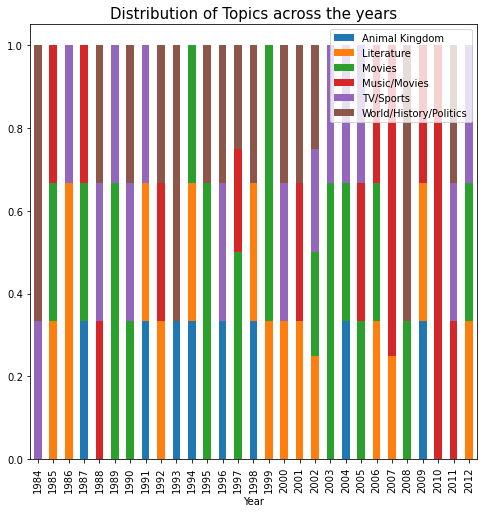

In [667]:
fig,ax=plt.subplots(1,figsize=(8,8))
df1_grouped.unstack('main_topics').plot.bar(stacked=True,ax=ax)
plt.legend(loc='upper right')
plt.title("Distribution of Topics across the years",fontsize=15)
plt.show()

## Table 1

In [669]:
df1A[['Year',' Round','main_topics']].pivot(index=' Round',columns=['Year'])

main_topics                            \
Year                                1984          1985        1986   
 Round                                                               
Double Jeopardy!  World/History/Politics        Movies  Literature   
Final Jeopardy!   World/History/Politics  Music/Movies   TV/Sports   
Jeopardy!                      TV/Sports    Literature  Literature   
Tiebreaker                           NaN           NaN         NaN   

                                                                     \
Year                        1987                    1988       1989   
 Round                                                                
Double Jeopardy!  Animal Kingdom               TV/Sports     Movies   
Final Jeopardy!     Music/Movies  World/History/Politics     Movies   
Jeopardy!                 Movies            Music/Movies  TV/Sports   
Tiebreaker                   NaN                     NaN        NaN   

                                                          \
Year                                1990            1991   
 Round                                                     
Double Jeopardy!  World/History/Politics       TV/Sports   
Final Jeopardy!                   Movies  Animal Kingdom   
Jeopardy!                      TV/Sports      Literature   
Tiebreaker                           NaN             NaN   

                                                                  ...  \
Year                                1992                    1993  ...   
 Round                                                            ...   
Double Jeopardy!              Literature  World/History/Politics  ...   
Final Jeopardy!   World/History/Politics          Animal Kingdom  ...   
Jeopardy!                   Music/Movies  World/History/Politics  ...   
Tiebreaker                           NaN                     NaN  ...   

                                                                         \
Year                   2003            2004          2005          2006   
 Round                                                                    
Double Jeopardy!  TV/Sports  Animal Kingdom        Movies    Literature   
Final Jeopardy!      Movies       TV/Sports     TV/Sports  Music/Movies   
Jeopardy!            Movies          Movies  Music/Movies        Movies   
Tiebreaker              NaN             NaN           NaN           NaN   

                                                                        \
Year                      2007                    2008            2009   
 Round                                                                   
Double Jeopardy!  Music/Movies  World/History/Politics      Literature   
Final Jeopardy!   Music/Movies                  Movies  Animal Kingdom   
Jeopardy!           Literature  World/History/Politics    Music/Movies   
Tiebreaker        Music/Movies                     NaN             NaN   

                                                                    
Year                      2010                    2011        2012  
 Round                                                              
Double Jeopardy!  Music/Movies            Music/Movies      Movies  
Final Jeopardy!   Music/Movies               TV/Sports   TV/Sports  
Jeopardy!         Music/Movies  World/History/Politics  Literature  
Tiebreaker                 NaN                     NaN         NaN  

[4 rows x 29 columns]

# Question 1 Conclusion
(a) how did the themes change from year to year. Were they relatively constant or were there noticable trends?
<br>
<br>
- From the plot1, we fix the first year's themes and analyze the trend from year to year. 
We can see the similarity scores for double jeopardy round are always in the range 0.5-0.7, which means the topics are relatively constant. 
- While the similarity scores for ordinary jeopardy round have a wider range 0.2-0.8, which means the topics change frequently compared to the first year's topic.
- From the plot4 we can also see that the theme expanded to Music,Literature in addition to Sports and Politics over the years
<br>
From the plot2, we compare the similarity scores between current year and previous year, the results for double and ordinary jeopardy round almost match (except a few outliers) with the outputs from plot2, so we can conclude that actually double jeopardy round focus on more similar topics each year than the ordinary jeopardy round. 
<br>
<br>


(b) how did the ’Final Jeopardy’ questions change over time? 
<br>
<br>
- Topics for final Jeopardy round change most frequently over time. From the summary statistics table 1 and 2, we can see the mean and median for final round similary scores are significantly lower than those for ordinary and double round.
<br>
- Especially the median value from table 2: final: 0.51, double: 0.67, ordinary: 0.64
<br>
<br>

(c) based on what you notice, do you think Jeopardy! has gotten easier or more difficult over time?
<br>
<br>
- From the plot3, we compare the similarity between 3 rounds for each year. In the first 10 years, it shows the double/ordinary round have similar topics, but later on the similarity scores drop, which means the game covers more topics for the first two easy round. Thus, we conclude Jeopardy has gotten difficult over time.

- From table1 we can see that the topics essentially became more complex over the years in Jeopardy
<br>
<br>


## Jeopardy Project
Goal: use unsupervised learning to analyze questions from the show

# Question 2A

Separately analyze’ Jeopardy’ and the ’Double Jeopardy’ questions across all time and identify topics of the questions asked according to their monetary value.

In [401]:
df2A = df[df[' Value'].str.strip(',').str[1:].apply(lambda x: str(x).isdigit())]
df2A['dollar_int'] = df2A[' Value'].str.strip(',').str[1:].astype(int)
df2A = df2A.dropna()

<AxesSubplot:>

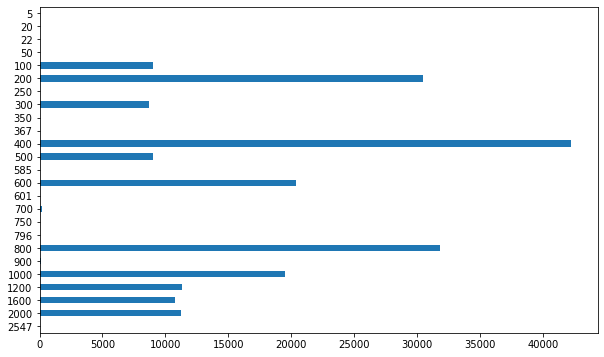

In [402]:
df2A.dollar_int.value_counts().sort_index(ascending=False).plot(kind='barh')

### Filtering Monetary Value
We only focused on the top representation of monetary values within each round. Thus, we eliminated the minor represented values seen in the plot above. 

In [403]:
df2A = df2A.groupby(["dollar_int",' Round']).filter(lambda x: len(x) > 1000)

<AxesSubplot:>

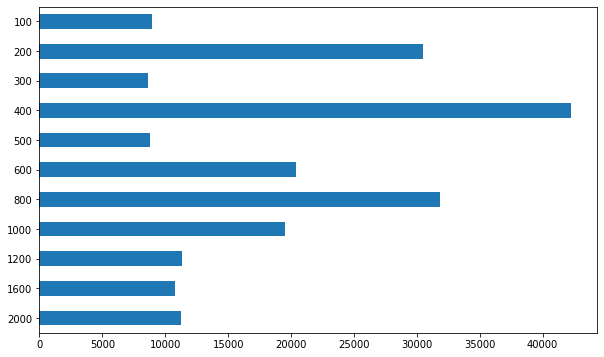

In [404]:
df2A.dollar_int.value_counts().sort_index(ascending=False).plot(kind='barh')

In [405]:
ques_lst = df2A.groupby(['dollar_int', ' Round'])[' Question'].apply(list)
df2A = pd.DataFrame(ques_lst).reset_index()

In [408]:
df2A = df2A.sort_values(by = [' Round','dollar_int'], ascending = [False, True])
#df2A

In [409]:
stop_words = stopwords.words('english')
stop_words.extend(['href', 'http', 'html', 'wwwj', 'archivecom', 'www', 'br', 'jpg'])

In [410]:
vectorizer = CountVectorizer(stop_words=set(stopwords.words('english')))

n2A = len(df2A)

topic_collection = []

for i in range(n2A):
    X = vectorizer.fit_transform(df2A[' Question'][i])

    vocab = vectorizer.get_feature_names()

    k = 20

    model = LatentDirichletAllocation(n_components=k, random_state=100)
    id_topic = model.fit_transform(X)

    topic = []

    for comp in model.components_:    
        word_idx = np.argsort(comp)[-1]
        topic.append(vocab[word_idx])

    topic_collection.append(topic)

In [411]:
df2A['Topics'] = topic_collection

### Calculate coherence values

In [150]:
stop_words = stopwords.words('english')

cv_collection = []
n2A = len(df2A)

data = df2A[' Question']
data_words = list(sent_to_words(data))
    
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
    
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
nlp.max_length = 2000000
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['ADJ', 'NOUN']) #['NOUN', 'ADJ', 'VERB', 'ADV']
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]
cv = []
for k in range(1, 11):
    cv.append(compute_coherence_values(corpus=corpus, dictionary=id2word, 
                                              k=k, data_lemmatized=data_lemmatized))
print(f'{i}:{[round(x, 4) for x in cv]}')
cv_collection.append(cv)

15:[0.2581, 0.2538, 0.2527, 0.2512, 0.2579, 0.2537, 0.2514, 0.2504, 0.2581, 0.2586]


In [153]:
pd.DataFrame(cv_collection).to_csv("cv2A_collection.csv", index=False)

In [412]:
cv_collection = pd.read_csv("cv2A_collection.csv")

Based on the coherence value the best number of topics is 10. 

In [299]:
np.argsort(np.median(cv_collection.values, axis=0))[::-1] + 1

array([10,  1,  9,  5,  2,  6,  3,  7,  4,  8])

### Jeopardy topics 
Thus, topic modeling is an unsupervised task; we can leverage our shared knowledge about the game of jeopardy and similar gameshows to identify topics. History, Geography, Literature, Mythology, and Sports are just a few samples of the issues that we have used for this purpose. The complete list of topics is listed below in the variable jeopardy_topics. After identifying these common jeopardy topics, we use word vectors to find similarity between our model's words for each topic and then assign it to the most similar jeopardy topics. This improves our ability to interpret, compare and visualize these changes in topics. 

In [413]:
jeopardy_topics = ['History','Geography','Culture', 'Business', 'Movies', 'Food', 'Literature', 'Music', 'Nature', 'Science', 
                   'Mythology', 'Sports', 'Arts', 'Languages', 'Politics']

In [278]:
import re

def get_topic_list(lda_model, n_topics, jeopardy_topics):
    top_topics = ["" for i in range(0, n_topics)]
    for i in range(0, n_topics):
        topic_i = lda_model.print_topics(num_words=10)[i]

        # extract topic_words from the topic in lda_model
        topic_words = []
        quoted = re.compile('"[^"]*"')
        for value in quoted.findall(topic_i[1]):
            topic_words.append(value[1:-1])
            
            # remove woards that throws errors 
            try:
                topic_words.remove('href_http')
            except: 
                pass
            try:
                topic_words.remove('media_jpg')
            except: 
                pass

            # check for lda_model topic similairty all jeopardy_topics and choose the topic with highest similairty
            max_score = 0
            for topic in jeopardy_topics:
                jeo_topic = [topic]
                score = (np.mean([np.max([word_vectors.similarity(x1, x2)
                                          for x1 in topic_words]) for x2 in jeo_topic]))
                if score > max_score:
                    max_score = score

                    # adds most similar topic to the top_topics list
                    top_topics[i] = topic

    # return a list of jeopardy_topics most similar to the words from the lda_model output
    return top_topics

In [279]:
stop_words = stopwords.words('english')


topics_collections = []

for i in range(0,len(df2A)):
    data = df2A[' Question'][i]
    data_words = list(sent_to_words(data))
    
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) 
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    
    data_words_nostops = remove_stopwords(data_words)
    data_words_bigrams = make_bigrams(data_words_nostops)
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['ADJ', 'NOUN']) #['NOUN', 'ADJ', 'VERB', 'ADV']
    id2word = corpora.Dictionary(data_lemmatized)
    texts = data_lemmatized
    corpus = [id2word.doc2bow(text) for text in texts]
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10)
    #pprint(lda_model.print_topics(num_words=3))
    
    topic_list = get_topic_list(lda_model, 10, jeopardy_topics)
    topics_collections.append(topic_list)

### Topic DataFrame

In [292]:
topics_collections = [set(i) for i in topics_collections]

In [298]:
Q2A_topics = df2A[['dollar_int',' Round']]
Q2A_topics['Topics'] = topics_collections
Q2A_topics['Topics'] = sorted(Q2A_topics['Topics'])

In [297]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
Q2A_topics.T

,0,2,3,5,6,8,10,12,1,4,7,9,11,13,14,15
dollar_int,100,200,300,400,500,600,800,1000,200,400,600,800,1000,1200,1600,2000
Round,Jeopardy!,Jeopardy!,Jeopardy!,Jeopardy!,Jeopardy!,Jeopardy!,Jeopardy!,Jeopardy!,Double Jeopardy!,Double Jeopardy!,Double Jeopardy!,Double Jeopardy!,Double Jeopardy!,Double Jeopardy!,Double Jeopardy!,Double Jeopardy!
Topics,"{Literature, Movies, Food, Languages, Music, Business}","{Literature, Culture, Geography, Movies, Nature, Music, Business}","{Movies, Food, Mythology, Nature, Music, Sports}","{Literature, Movies, Sports, Music, Business}","{Literature, Movies, Mythology, Music, Business}","{History, Movies, Food, Nature, Music, Sports}","{Culture, Movies, Nature, Music, Business}","{Literature, Languages, Movies, Music}","{Literature, Culture, Movies, Food, Music, Sports}","{Literature, Culture, Movies, Business, Music, Sports}","{Literature, Culture, Movies, Mythology, Music, Sports}","{Literature, Movies, Politics, Mythology, Music}","{Literature, Movies, Languages, Nature, Music, Sports}","{Literature, Culture, Movies, Food, Music}","{Literature, Culture, History, Movies, Food, Nature, Music}","{Literature, Movies, Languages, Mythology, Nature, Music}"


The dataframe above identifies topics of the questions asked for each monetary value and Jeopardy! and Double Jeopardy! questions.

In [335]:
score_collection = []
for i in Q2A_topics.Topics:
    score_collection.append([similarity_score(i, j) for j in Q2A_topics.Topics])

In [337]:
pd.DataFrame(score_collection).to_csv("score_collection.csv", index=False)

In [386]:
columns = [] 
for row in Q2A_topics.iterrows():
    inst = row[1][' Round'] + " $" + str(row[1]['dollar_int']) #print(row[1][' Round'], row[1]['dollar_int'])
    columns.append(inst)

In [387]:
score_collection = pd.read_csv("score_collection.csv")
score_collection.columns = columns

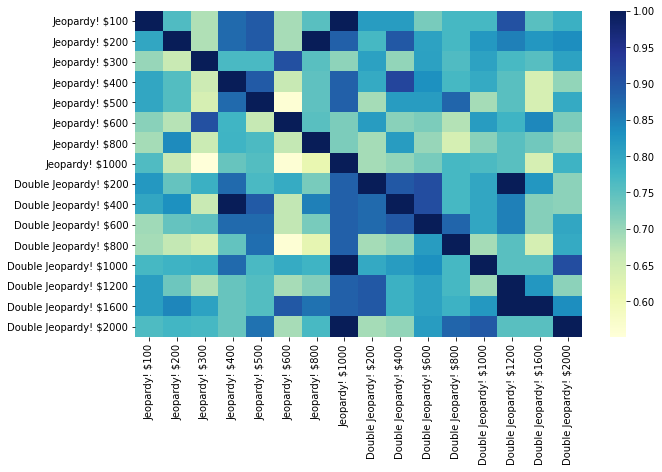

In [390]:
ax = sns.heatmap(score_collection,yticklabels=columns,cmap='YlGnBu')

## Question 2A Conclusion
- When we compare and contrast the topics identified for each value, we find no inherent difference. We can also look at the heat plot above, and we can notice that the similarity is very random. 
- Thus, the topics are not noticeably different; rather, the question of the subject might be more difficult.
- There are no questions that seem to be more difficult based on similarity or difference in the monetary values associated with this topic.

The only takeaway from the above topic exploration is that: 

- the hardest double jeopardy topics are similar to the hardest jeopardy topics 
- the early double jeopardy topics are closely similar

# Q2b)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1f002313-2e89-4f3a-b2f3-9e2c540a15da' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

In [267]:
import pandas as pd
import numpy as np
import gensim
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim import downloader

In [293]:
def pre_process(df):
    df['question'] = df['question'].map(lambda x: re.sub('[,\.!?]', '', x.lower()))
    df['tokens'] = df['question'].apply(lambda x: gensim.utils.simple_preprocess(str(x), deacc=True))
    df['tokens_no_stop_word'] = df['tokens'].apply(lambda x: [t for t in x if t not in stop_words and len(t) > 2])
    df['tokens_no_stop_word'] = df['tokens_no_stop_word'].apply(lambda x: [lemmatizer.lemmatize(token) for token in x])

def train_model(docs):
    bigram = Phrases(docs, min_count=20)
    
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                docs[idx].append(token)

    dictionary = Dictionary(docs)
    dictionary.filter_extremes(no_below=20, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in docs]
    
    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents: %d' % len(corpus))
    
    # seems to be the most appropriate value from experiment
    num_topics = 6
    chunksize = 100
    random_state=100
    passes = 10
    eval_every = None

    temp = dictionary[0]
    id2word = dictionary.id2token

    model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        num_topics=num_topics,
        passes=passes,
        random_state=random_state,
        eval_every=eval_every
    )

    return dictionary, corpus, model


def get_topic_list(lda_model):
    jeopardy_topics = ['History','Geography','Culture', 'Business', 'Films', 'Food', 'Literature', 'Music', 'Nature', 'Science', 
                   'Mythology', 'Art', 'Politics']

    top_topics = {}
    word_vectors = KeyedVectors.load('vectors.kv')
    quoted = re.compile('"[^"]*"')

    for i, topic_i in enumerate(lda_model.print_topics(num_words=10)):
        topic_words = []

        for value in quoted.findall(topic_i[1]):
            if '_' in value:
                topic_words.extend(value[1:-1].split('_'))
            else:
                topic_words.append(value[1:-1])
                
            if 'ajpg' in topic_words:
                topic_words.remove('ajpg')
            
            max_score = 0
            for topic in jeopardy_topics:
                jeo_topic = [topic]
                score = (np.mean([np.max([word_vectors.similarity(x1, x2)
                                          for x1 in topic_words]) for x2 in jeo_topic]))
                if score > max_score:
                    max_score = score
                    # adds most similar topic to the top_topics list
                    top_topics[i] = topic
    # return a list of jeopardy_topics most similar to the words from the lda_model output
    return top_topics

In [89]:
stop_words = stopwords.words('english')
stop_words.extend(['href', 'http', 'html', 'wwwj', 'archivecom', 'www', 'br', 'jpg'])
lemmatizer = WordNetLemmatizer()

In [179]:
df = pd.read_csv('data/jeopardy_question.csv')
relavent_data = df[(df['value'] <= 2000) & ((df['round'] == 'Jeopardy!') | (df['round'] == 'Double Jeopardy!'))][['category', 'question', 'value', 'round', '']].copy()

In [182]:
pre_process(relavent_data)

In [184]:
jeo_df = relavent_data[relavent_data['round'] == 'Jeopardy!'].reset_index(drop=True).copy()
doujeo_df = relavent_data[relavent_data['round'] == 'Double Jeopardy!'].reset_index(drop=True).copy()

In [188]:
jeo_docs = jeo_df['tokens_no_stop_word'].to_list()
doujeo_docs = doujeo_df['tokens_no_stop_word'].to_list()

In [189]:
jeo_dic, jeo_cor, jeo_mod = train_model(jeo_docs)
doujeo_dic, doujeo_cor, doujeo_mod = train_model(doujeo_docs)

Number of unique tokens: 6172
Number of documents: 103380


In [252]:
jeo_mod.print_topics()

[(0,
  '0.017*"first" + 0.013*"name" + 0.013*"also" + 0.011*"woman" + 0.011*"called" + 0.011*"became" + 0.010*"known" + 0.007*"one" + 0.007*"like" + 0.007*"set"'),
 (1,
  '0.028*"city" + 0.022*"state" + 0.017*"new" + 0.012*"day" + 0.012*"year" + 0.011*"island" + 0.010*"capital" + 0.010*"river" + 0.009*"country" + 0.009*"seen_medium"'),
 (2,
  '0.017*"one" + 0.011*"type" + 0.011*"company" + 0.011*"used" + 0.010*"term" + 0.010*"make" + 0.009*"like" + 0.008*"animal" + 0.008*"letter" + 0.007*"top"'),
 (3,
  '0.019*"world" + 0.016*"one" + 0.015*"word" + 0.010*"country" + 0.009*"back" + 0.008*"say" + 0.008*"first" + 0.007*"war" + 0.007*"meaning" + 0.007*"year"'),
 (4,
  '0.017*"film" + 0.017*"name" + 0.012*"one" + 0.010*"title" + 0.010*"mean" + 0.008*"played" + 0.008*"series" + 0.007*"character" + 0.007*"book" + 0.007*"john"'),
 (5,
  '0.062*"medium" + 0.051*"target" + 0.030*"medium_target" + 0.027*"seen" + 0.022*"clue" + 0.016*"crew" + 0.009*"ajpg" + 0.008*"medium_ajpg" + 0.007*"one" + 0.00

In [253]:
doujeo_mod.print_topics()

[(0,
  '0.022*"city" + 0.016*"world" + 0.014*"first" + 0.012*"state" + 0.012*"capital" + 0.012*"river" + 0.010*"one" + 0.009*"south" + 0.008*"big" + 0.008*"mile"'),
 (1,
  '0.021*"film" + 0.017*"title" + 0.014*"novel" + 0.013*"play" + 0.013*"first" + 0.012*"played" + 0.011*"wrote" + 0.010*"book" + 0.009*"name" + 0.009*"character"'),
 (2,
  '0.014*"new" + 0.014*"president" + 0.013*"year" + 0.012*"city" + 0.011*"country" + 0.011*"first" + 0.010*"king" + 0.008*"founded" + 0.008*"state" + 0.007*"home"'),
 (3,
  '0.033*"name" + 0.021*"word" + 0.018*"one" + 0.012*"used" + 0.012*"letter" + 0.011*"mean" + 0.011*"term" + 0.011*"known" + 0.010*"come" + 0.009*"like"'),
 (4,
  '0.061*"medium" + 0.050*"target" + 0.032*"medium_target" + 0.025*"clue" + 0.023*"seen" + 0.022*"crew" + 0.010*"seen_medium" + 0.009*"ajpg" + 0.009*"show" + 0.008*"medium_ajpg"'),
 (5,
  '0.014*"one" + 0.010*"called" + 0.010*"american" + 0.010*"work" + 0.010*"song" + 0.008*"island" + 0.008*"country" + 0.008*"found" + 0.007*"k

In [294]:
jeo_topics = get_topic_list(jeo_mod)
doujeo_topics = get_topic_list(doujeo_mod)

In [197]:
jeo_df['topics'] = jeo_mod[jeo_cor]
doujeo_df['topics'] = doujeo_mod[doujeo_cor]

/Users/lemon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [300]:
jeo_df['most_common_topic'] = jeo_df['topics'].apply(lambda x: max(x, key=lambda t: t[1])[0])
doujeo_df['most_common_topic'] = doujeo_df['topics'].apply(lambda x: max(x, key=lambda t: t[1])[0])

In [301]:
jeo_df['topic_name'] = jeo_df['most_common_topic'].map(jeo_topics)
doujeo_df['topic_name'] = doujeo_df['most_common_topic'].map(doujeo_topics)

In [390]:
jeo_max_top_by_year = jeo_df[['value', 'year', 'topic_name']].groupby(['value', 'year']).apply(pd.DataFrame.mode).reset_index(drop=True).dropna()
doujeo_max_top_by_year = doujeo_df[['value', 'year', 'topic_name']].groupby(['value', 'year']).apply(pd.DataFrame.mode).reset_index(drop=True).dropna()

In [333]:
colors = ['#b3b3ff', '#8080ff', '#3333ff', '#0000ff', '#00004d', '#00001a']

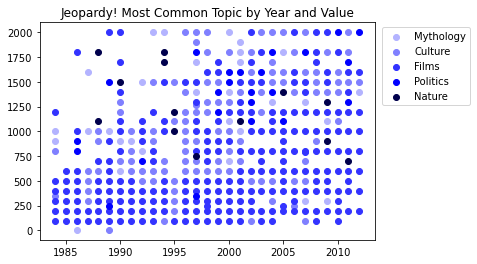

In [334]:
for i, topic in enumerate(jeo_max_top_by_year['topic_name'].unique()):
    plt.scatter(
        jeo_max_top_by_year[jeo_max_top_by_year['topic_name'] == topic]['year'].values,
        jeo_max_top_by_year[jeo_max_top_by_year['topic_name'] == topic]['value'].values,
        color=colors[i],
        label=topic,
    )
plt.title('Jeopardy! Most Common Topic by Year and Value')
plt.legend(bbox_to_anchor=(1.3,1), loc='upper right')
plt.show()

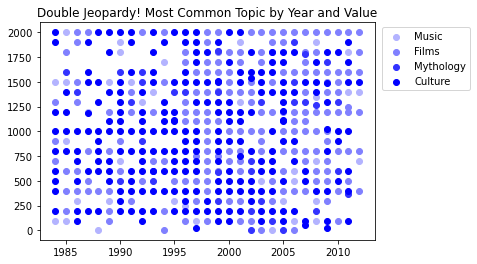

In [335]:
for i, topic in enumerate(doujeo_max_top_by_year['topic_name'].unique()):
    plt.scatter(
        doujeo_max_top_by_year[doujeo_max_top_by_year['topic_name'] == topic]['year'].values,
        doujeo_max_top_by_year[doujeo_max_top_by_year['topic_name'] == topic]['value'].values,
        color=colors[i],
        label=topic,
    )
plt.title('Double Jeopardy! Most Common Topic by Year and Value')
plt.legend(bbox_to_anchor=(1.3,1), loc='upper right')
plt.show()

# Q2 b) Conclusion 1:

Based on these two plots, it appear that in the earlier year of Jeopardy, there are fewer difficult question than double jeopardy. The there is no super clear separation in terms of topics between different price range. For Jeopardy, it looks like most common the questions by category are related to films regardless of price range. For Double Jeopardy, the most common questions are related to Culture; the most difficult problems in the earlier years were more related to Culture, but the most difficult problems in the related to Music and Films.

To get a better sense of what are the most difficult versus easy problem over the year, we will be grouping questions with price greater than or equal to 1500 as difficult and price less than or equal to 500 as easy.

In [413]:
jeo_difficulty_df = jeo_df[(jeo_df['value'] >= 1500) | (jeo_df['value'] <= 500)].reset_index(drop=True).copy()
doujeo_difficulty_df = doujeo_df[(doujeo_df['value'] >= 1500) | (doujeo_df['value'] <= 500)].reset_index(drop=True).copy()

In [414]:
jeo_difficulty_df['easy'] = np.where(jeo_difficulty_df['value'] <= 500, True, False)
doujeo_difficulty_df['easy'] = np.where(doujeo_difficulty_df['value'] <= 500, True, False)

In [415]:
jeo_difficulty_df = jeo_difficulty_df.groupby(['year', 'topic_name', 'easy']).count()['most_common_topic'].reset_index()
doujeo_difficulty_df = doujeo_difficulty_df.groupby(['year', 'topic_name', 'easy']).count()['most_common_topic'].reset_index()

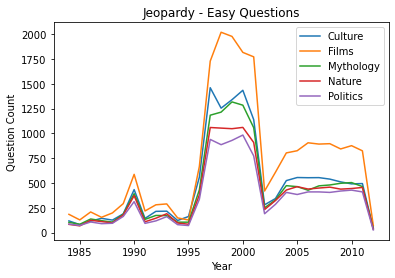

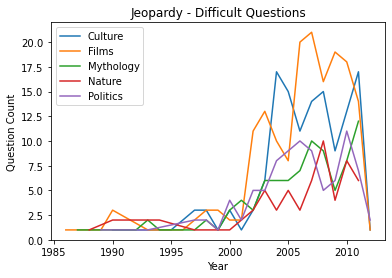

In [444]:
topics = ['Culture', 'Films', 'Mythology', 'Nature', 'Politics']

easy = jeo_difficulty_df[jeo_difficulty_df['easy']].copy()
for topic in topics:
    plt.plot(
        easy[easy['topic_name'] == topic]['year'],
        easy[easy['topic_name'] == topic]['most_common_topic'],
        label=topic,
    )

plt.legend()
plt.title('Jeopardy - Easy Questions')
plt.ylabel('Question Count')    
plt.xlabel('Year')
plt.show()
    
difficult = jeo_difficulty_df[~jeo_difficulty_df['easy']].copy()
for topic in topics:
    plt.plot(
        difficult[difficult['topic_name'] == topic]['year'],
        difficult[difficult['topic_name'] == topic]['most_common_topic'],
        label=topic,
    )

plt.legend()
plt.title('Jeopardy - Difficult Questions')
plt.ylabel('Question Count')
plt.xlabel('Year')
plt.show()

# Question 2: Conclusion 2

For easy Jeopardy questions, the topics of the questions are equally distributed up until around 1995. After that, questions related to films had the highest increase among all other topics, and remained the most frequent question. The topic with the lowest count is politics. There is significantly fewer difficult questions compared to easy questions through the entire time range and there is an increase in count after 2000. However, in general, most questions are related to films and the lowest are related to natures.

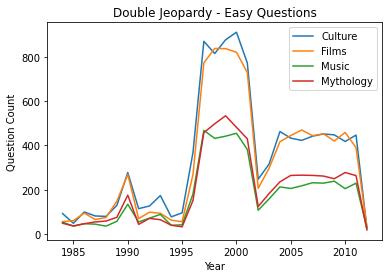

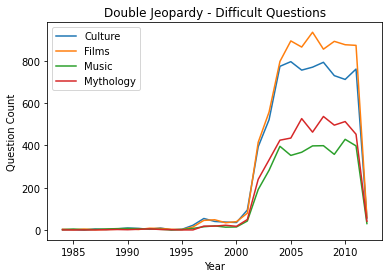

In [440]:
easy = doujeo_difficulty_df[doujeo_difficulty_df['easy']].copy()
for topic in easy['topic_name'].unique():
    plt.plot(
        easy[easy['topic_name'] == topic]['year'],
        easy[easy['topic_name'] == topic]['most_common_topic'],
        label=topic,
    )

plt.legend()
plt.title('Double Jeopardy - Easy Questions')
plt.ylabel('Question Count')    
plt.xlabel('Year')
plt.show()
    
difficult = doujeo_difficulty_df[~doujeo_difficulty_df['easy']].copy()
for topic in difficult['topic_name'].unique():
    plt.plot(
        difficult[difficult['topic_name'] == topic]['year'],
        difficult[difficult['topic_name'] == topic]['most_common_topic'],
        label=topic,
    )

plt.legend()
plt.title('Double Jeopardy - Difficult Questions')
plt.ylabel('Question Count')
plt.xlabel('Year')
plt.show()

For Double Jeopardy, the general pattern of change in frequency matches the plot for Jeopardy: a sharp increase in count around 1995 for easy questions, and a sharp increase in difficult questions after 2000. Double jeopardy had a lot more difficult questions than Jeopardy did.

The highest count are culture and film for both easy and difficult questions. Around 2003, more difficult questions are related to film rather than culture, while the count for easy questions related film and culture remain similar to each other. The lowest two are Music and Mythology for both easy and difficult questions.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1f002313-2e89-4f3a-b2f3-9e2c540a15da' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>